# GMM and EM
Gaussian Mixture Models and Expectation Maximization

Link to [mastery](https://machinelearningmastery.com/expectation-maximization-em-algorithm/)

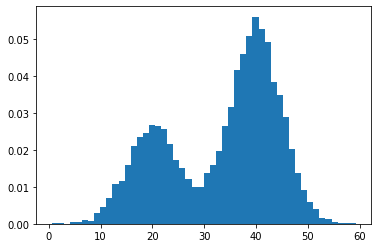

In [1]:
# Straight from the Mastery site.
# Construct a bimodal from two Gaussian processes.
from numpy import hstack
from numpy.random import normal
from matplotlib import pyplot
# normal ( mean, standard deviation, count )
def plot(X1,X2):
    X = hstack( (X1, X2) )  # horizontal stack i.e. concat
    pyplot.hist(X, bins=50, density=True)
    pyplot.show()
X1 = normal(loc=20, scale=5, size=3000) 
X2 = normal(loc=40, scale=5, size=6000)
plot(X1,X2)

In [2]:
def show_gmm(model):
    print(model)
    for i in range(model.n_components):
        print('Gaussian',i,'mean=',model.means_[i],
            'wgt=',model.weights_[i], 
            'Cov=',model.covariances_[i])

In [3]:
# Straight from the Mastery site.
# Use EM to reverse engineer the model i.e. fit a GMM to the data.
from sklearn.mixture import GaussianMixture
X = hstack( (X1, X2) ) 
X = X.reshape((len(X), 1))
# By default, covariance=‘full’: each component has its own general covariance matrix.
# Use 'spherical' (one variance per mean) since our data has only one feature.
# By default, init_params='kmeans'. Works much better than 'random'!
model = GaussianMixture(n_components=2, verbose=1, covariance_type='spherical')
model.fit(X)
show_gmm(model)

Initialization 0
Initialization converged: True
GaussianMixture(covariance_type='spherical', n_components=2, verbose=1)
Gaussian 0 mean= [40.01399924] wgt= 0.6628168142073987 Cov= 24.699344515352667
Gaussian 1 mean= [20.13804985] wgt= 0.33718318579260065 Cov= 25.66378400545523


In [4]:
yhat = model.predict(X)
print('Predicted class of a point on the left:',yhat[100])
print('Predicted class of a point on the right:',yhat[-100])

Predicted class of a point on the left: 1
Predicted class of a point on the right: 0


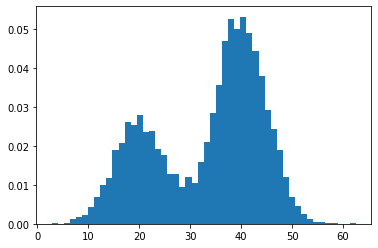

In [7]:
mean0=model.means_[0]
mean1=model.means_[1]
G0 = normal(loc=mean0, scale=5, size=3000) 
G1 = normal(loc=mean1, scale=5, size=6000)
if mean0>mean1:
    G0 = normal(loc=mean0, scale=5, size=6000) 
    G1 = normal(loc=mean1, scale=5, size=3000)
plot(G0,G1)